# ArXiv Citation Network

### Author: Dennis NUNEZ-FERNANDEZ

## Load libraries

In [1]:
# Installing addional libraries

#!pip install networkx
#!pip install powerlaw

In [2]:
# Importing libraries

import pandas as pd
import networkx as nx
import collections
import statistics as stats
import time
import seaborn as sns
import json
import numpy as np
import random  
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import powerlaw 
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

## Loading Data

In [3]:
# Reading the json file

f = open("data/internal-references-pdftotext.json")
data = json.load(f)

In [4]:
# Show how the data is presented

list(data.items())[50:60]

[('alg-geom/9504005', []),
 ('alg-geom/9504017', []),
 ('alg-geom/9504008', []),
 ('alg-geom/9504006', ['alg-geom/9412003', 'alg-geom/9503003']),
 ('alg-geom/9504010', []),
 ('alg-geom/9504007', []),
 ('alg-geom/9504012', []),
 ('alg-geom/9504001', []),
 ('alg-geom/9504004', []),
 ('alg-geom/9504002', ['alg-geom/9407002'])]

In [5]:
# Length of the data

orig_len = len(data)
print(orig_len)

1354753


In [6]:
# Get N elements in the dictionary, because of limited computational resources

n_sample = 50000 

random.seed(12)
data = dict(random.sample(data.items(), n_sample))  
#data = dict(list(data.items())[:n_sample])  #first elements
#data = data  #all the data

print("Working with the "+str(round(100*len(data)/orig_len,2))+"% of the original data")

Working with the 3.69% of the original data


## Some Pre-Processing

In [7]:
# Consider only papers with more than 4 citations

keys = []
for key, value in data.items():
    if len(value) >= 4:
        keys.append(key)

data = { your_key: data[your_key] for your_key in keys }

In [8]:
# Show how the data is presented

list(data.items())[0:4]

[('1305.6078', ['1209.3632', '0710.3453', '1203.2035', '0905.2942']),
 ('1402.4257', ['1303.2274', '1312.2168', '1301.3172', '1201.1944']),
 ('hep-lat/0003001',
  ['hep-lat/9909150',
   'hep-lat/9905003',
   'hep-lat/9911009',
   'hep-lat/9909042',
   'hep-lat/9912020',
   'hep-lat/9909135']),
 ('hep-th/0612006',
  ['hep-th/0411235', 'hep-th/0610308', 'hep-th/0312109', 'hep-th/0401023'])]

In [9]:
# Construct the dataframe

papers_main = []
papers_refs = []

for key in data:
    if len(data[key])!=0:
        #print("")
        #print(key, "->", data[key])
        for _ in range(len(data[key])):
            #print(key, data[key][_])
            papers_main.append(key)
            papers_refs.append(data[key][_])

# Sanity check
print(len(papers_main))
print(len(papers_refs))

# The TOP papers are the cited and the SUB, the ones that cited
df = pd.DataFrame({'top':papers_refs, 'sub':papers_main})

# Sanity check
print(len(df))

223196
223196
223196


In [10]:
print(df.shape)
df.head()

(223196, 2)


top        sub
0  1209.3632  1305.6078
1  0710.3453  1305.6078
2  1203.2035  1305.6078
3  0905.2942  1305.6078
4  1303.2274  1402.4257

In [11]:
# Remove duplicates rows

df = df.drop_duplicates(keep=False, inplace=False)

In [12]:
print(df.shape)
df.head()

(223196, 2)


top        sub
0  1209.3632  1305.6078
1  0710.3453  1305.6078
2  1203.2035  1305.6078
3  0905.2942  1305.6078
4  1303.2274  1402.4257

In [13]:
# Consider only the TOP papers that cite other papers, not those that do not cite any other paper

intersection = list(set(list(df["top"])).intersection(list(df["sub"])))

papers_top = []
papers_sub = []
for idx in range(0,len(df)):
    if (df["top"].iloc[idx] in intersection):
        papers_top.append(df["top"].iloc[idx])
        papers_sub.append(df["sub"].iloc[idx])

df = pd.DataFrame({'top':papers_top, 'sub':papers_sub})

In [14]:
print(df.shape)
df.head()

(5907, 2)


top             sub
0       1203.1090      1504.01801
1  hep-th/0104081  hep-th/0404174
2       1208.1428      1705.01937
3  hep-th/0104081    math/0210451
4       1405.0416      1703.00448

In [15]:
# Saving for later use in Cytoscape

df.to_csv("cytoscape/citations_network.csv", sep='\t', encoding='utf-8', index=False)

## Creation of the Citation Network

In [16]:
GG = nx.from_pandas_edgelist(df, source="top",
                              target="sub", edge_attr=None,
                              create_using=nx.DiGraph())
print(nx.info(GG))

Name: 
Type: DiGraph
Number of nodes: 5195
Number of edges: 5907
Average in degree:   1.1371
Average out degree:   1.1371


## Selection of the largest Weakly Connected Components in Citation Network

Weakly Connected Components: Group all the nodes in the graph that can access all of the nodes in the group throught undirected edges (lines)

In [17]:
GG_cc = max(nx.weakly_connected_components(GG), key=len)
GG = GG.subgraph(GG_cc)

In [18]:
print(nx.info(GG))

Name: 
Type: DiGraph
Number of nodes: 3204
Number of edges: 4515
Average in degree:   1.4092
Average out degree:   1.4092


## Visualization of the Citation Network using NetworkX

Warning: This step takes a loong time

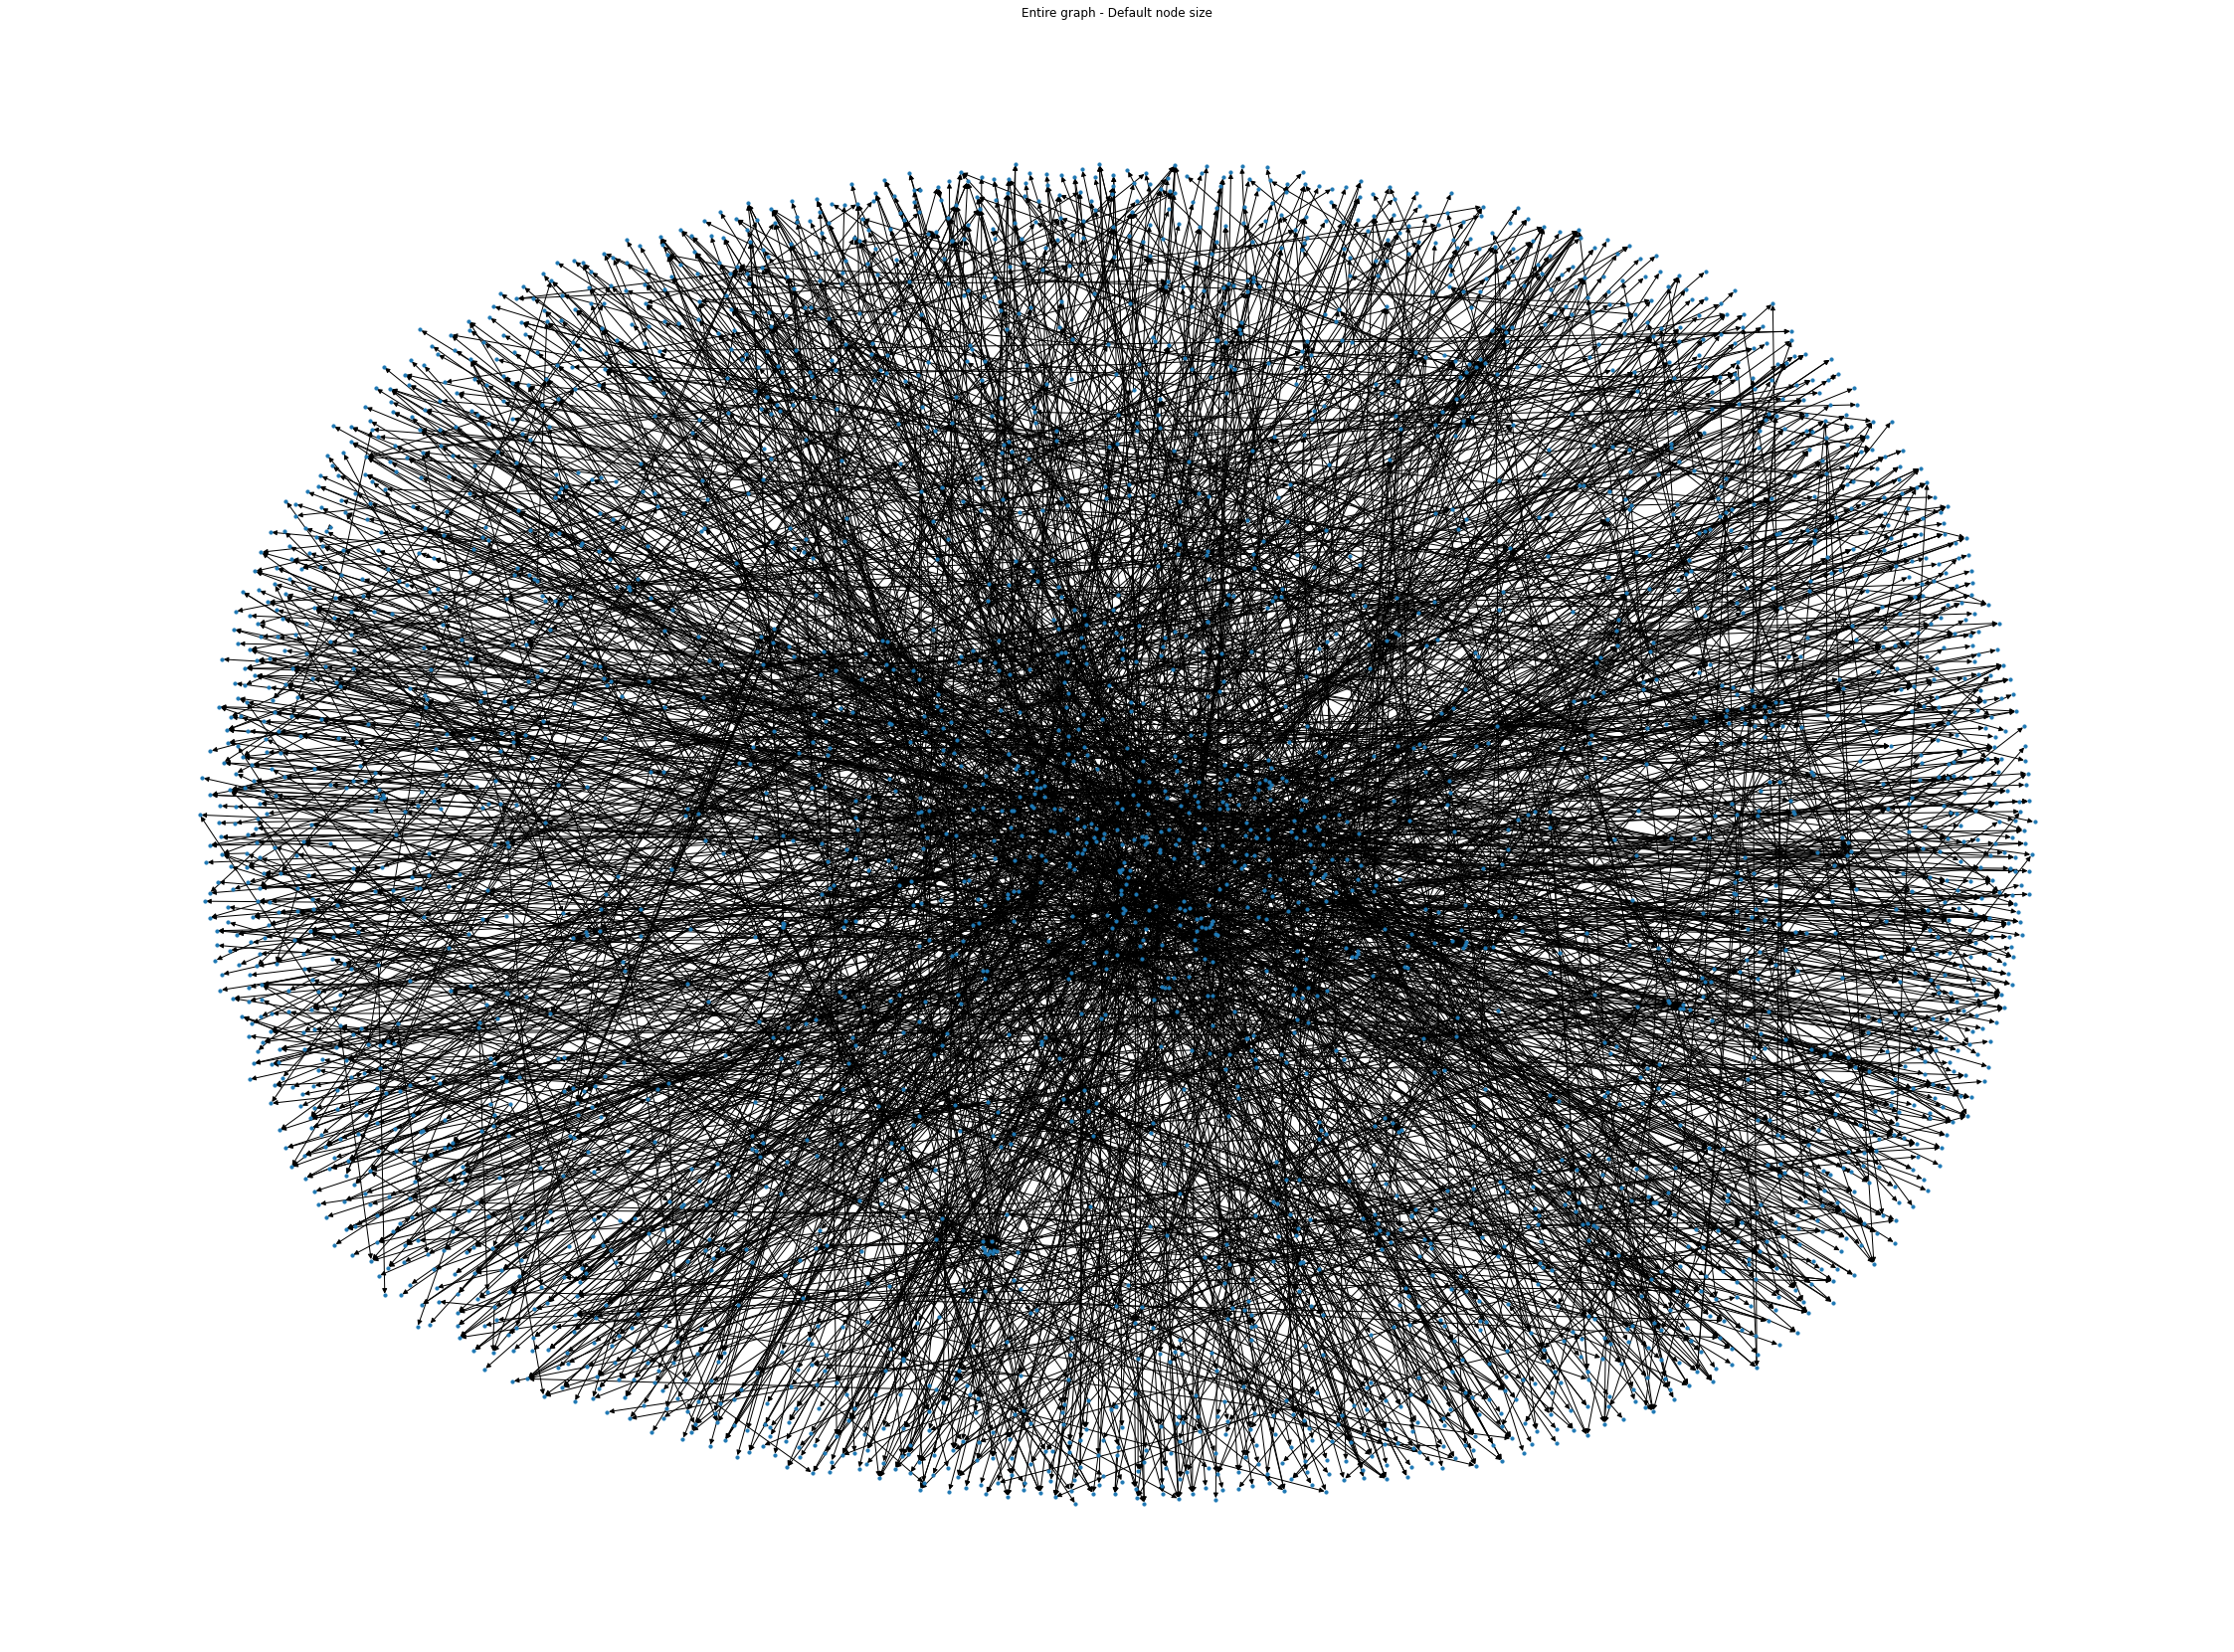

In [19]:
# The direction of the arrow indicates flow of information 
# from the cited paper (beginning of the arrow) to the citing paper (end of the arrow)

spring_pos = nx.spring_layout(GG) # might take a little while
fig = plt.figure(figsize = (40, 30))
ax = fig.add_subplot(111)
ax.axis('off')

nx.draw_networkx(GG, spring_pos, ax = ax, node_size = 10, width = 1, with_labels = False)
plt.title("Entire graph - Default node size")
plt.close();

fig

## Review of the power law-distribution

**i) Recognizing  that is a power-law distribution:**

- Distribution is right skewed
- High ratio of max to min

**ii) Discrete probability power law-distribution, indexed by the degree value k (k greater than $k_{min})$**

$p(k) = \frac{\alpha-1}{k_{min}}.(\frac{k}{k_{min}})^{-\alpha}$

- $\alpha$ is the power in the **power-law**
- $k_{min}$ is the minimum degree for which the **discrete probability law** applies

Let us take the logarithm on each side:

For degree k greater than $k_{min}$:
$log(p(k)) = log(\frac{\alpha-1}{k_{min}}) - \alpha.log(\frac{k}{k_{min}})$

The above expression is linear in $log(\frac{k}{k_{min}})$.

**iii) Analogy with linear function: y = cx + b**

- $y = log(p(k))$
- $x = log(\frac{k}{k_{min}})$ 
- Intercept: $b = log(\frac{\alpha-1}{k_{min}})$
- Slope: $c = -\alpha$

## In-degree distribution and fitting by a power-law distribution

In [20]:
# Calculating the in-degree

GGs = [d for d in list(set(list(GG.nodes)))]
GGs_in_degrees = [GG.in_degree[d] for d in GGs]

GGs_in_order = [x for y, x in sorted(zip(GGs_in_degrees, GGs), reverse=True)]
GGs_in_degrees_order = sorted((GG.in_degree[d] for d in GGs), reverse=True)

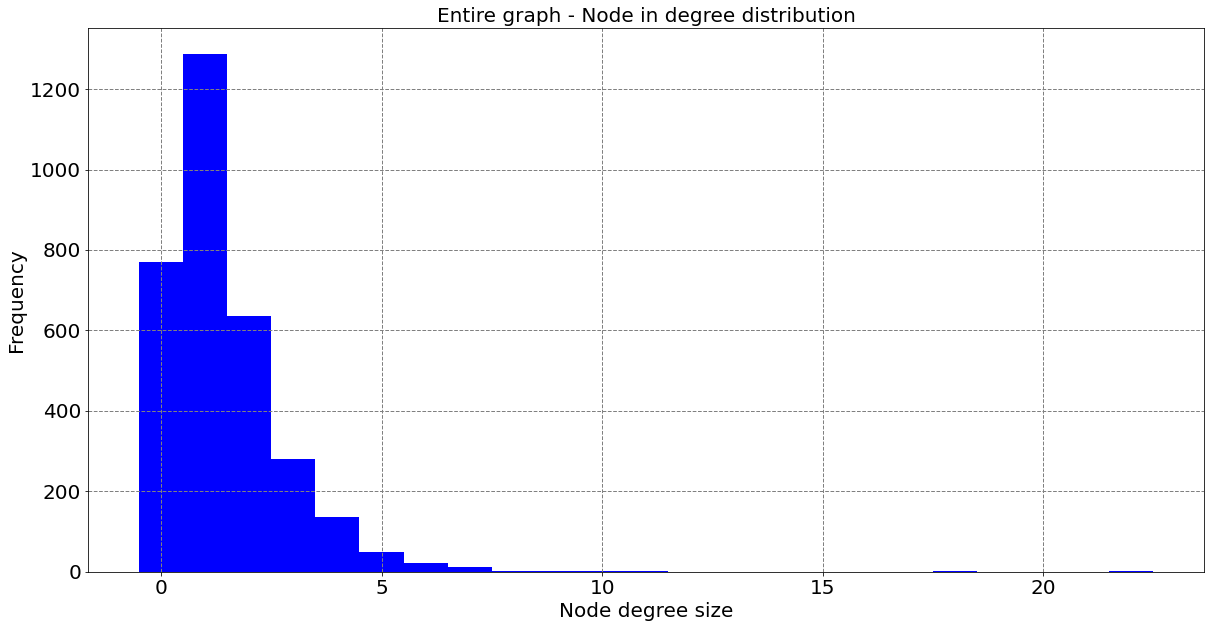

In [21]:
# Plotting the in-degree distribution

degree_count = collections.Counter(GGs_in_degrees_order)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(20,10))

plt.bar(deg, cnt, width=1, color='b')
plt.xlabel("Node degree size", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Entire graph - Node in degree distribution", fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.rc('axes', axisbelow=True)
plt.show()

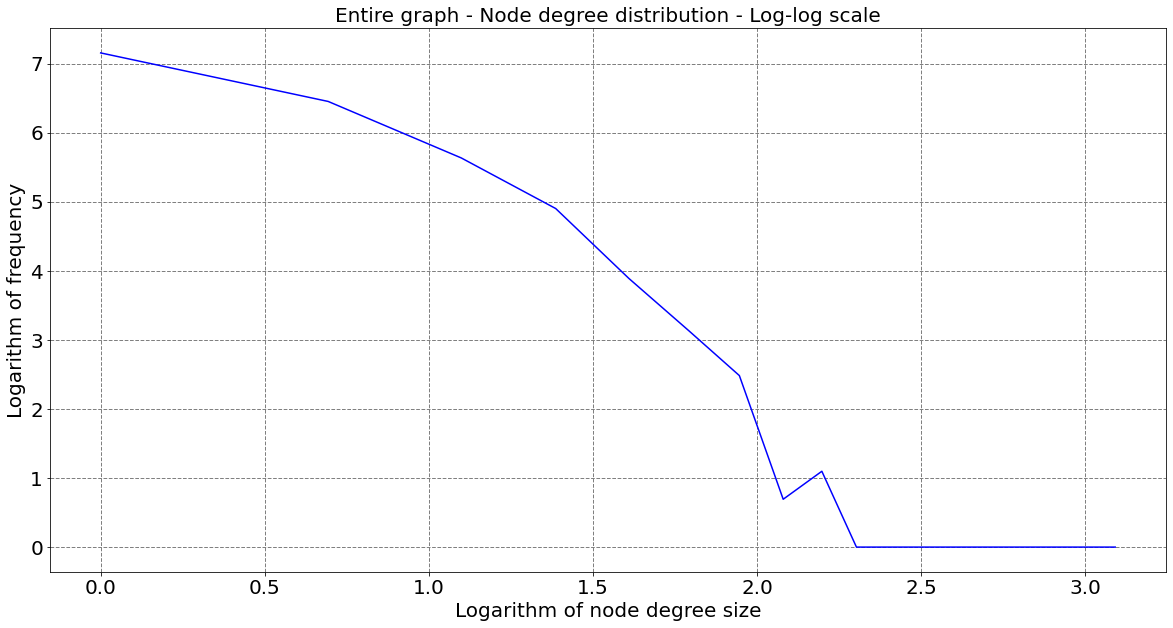

In [22]:
# It should look linear on a log-log scale

log_deg = np.log(deg)
log_cnt = np.log(cnt)

plt.figure(figsize=(20,10))

plt.plot(log_deg, log_cnt, color='b')
plt.xlabel('Logarithm of node degree size', fontsize=20)
plt.ylabel('Logarithm of frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Entire graph - Node degree distribution - Log-log scale", fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.rc('axes', axisbelow=True)
plt.show()

In [23]:
# Fitting a power law distribution

In [24]:
# Power laws are probability distributions with the form:p(x)∝x−α

# Used for degree distribution and powerlaw test
in_degree_sequence = sorted([d for n, d in GG.in_degree()], reverse=True) 

fit = powerlaw.Fit(in_degree_sequence) 

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [25]:
print("alpha:", round(fit.power_law.alpha,3))
print("Kmin:", round(fit.power_law.xmin,3))

alpha: 6.358
Kmin: 7.0


In [26]:
print("Intercept:", round(np.log((fit.power_law.alpha-1)/fit.power_law.xmin),3))
print("Slope:", round(-1*fit.power_law.alpha,3))

Intercept: -0.267
Slope: -6.358


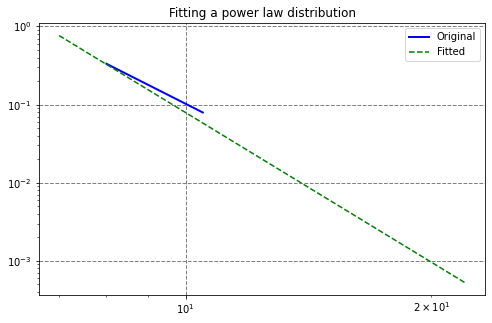

In [27]:
# Plotting the fitted a power law distribution

plt.figure(figsize=(8, 5))
fig2 = fit.plot_pdf(color='b', linewidth=2, label='Original')
fig2 = fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2, label='Fitted')
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.title("Fitting a power law distribution")
plt.rc('axes', axisbelow=True)
plt.legend()

In [28]:
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("R:", R)
print("p:", p)

R: 3.1971757789417175
p: 0.0013878032770177863


Discussion: As can be seen above, the in degree distribution has the following characteristics: the distribution is right skewed and has a high ratio of max to min. This gives us an indication that it can be very well matched with a power-law distribution. And indeed, in the above procedure it is verified that the in degree distribution fits very well with a power-law distribution. In fact, the likelihood ratio test comparisons produces a pair (R,p), where r is the normalized log likelihood ratio and p is the statistical significance of that ratio. So, being tested for the p-value is whether the sign of r is meaningful. As we can see, we obtained a p<0.05 for a likelihood ratio test, this indicates that the power-law model is favored.

## Out-degree distribution and fitting by a power-law distribution

In [29]:
# Calculating the out-degree

GGs = [d for d in list(set(list(GG.nodes)))]
GGs_out_degrees = [GG.out_degree[d] for d in GGs]

GGs_out_order = [x for y, x in sorted(zip(GGs_out_degrees, GGs), reverse=True)]
GGs_out_degrees_order = sorted((GG.out_degree[d] for d in GGs), reverse=True)

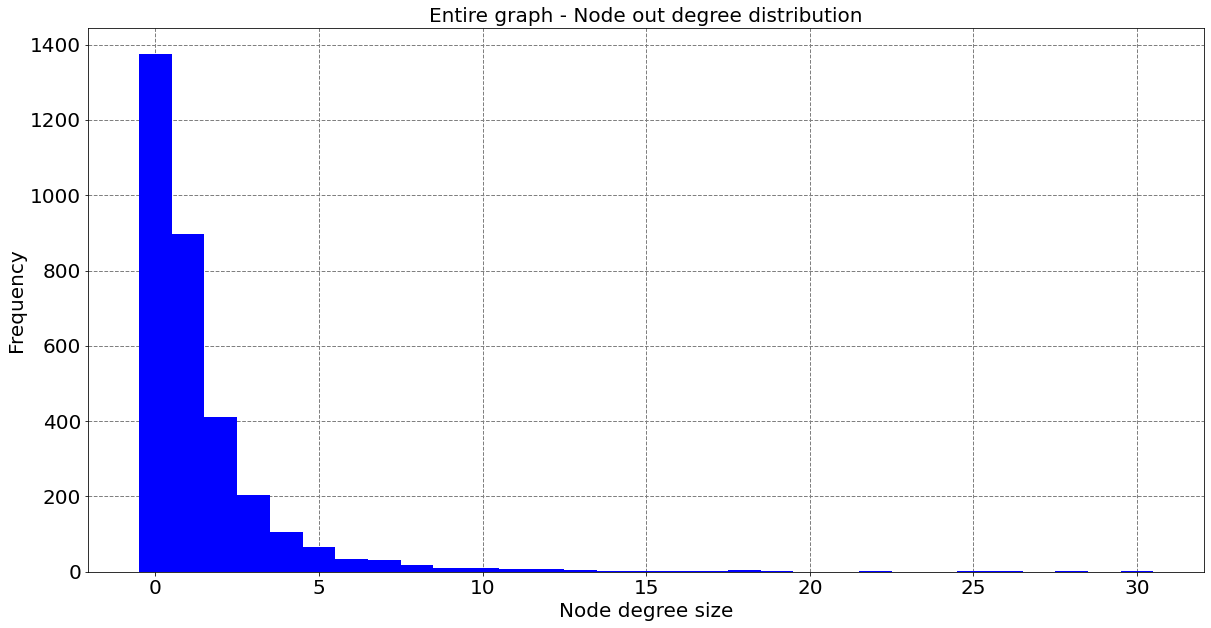

In [30]:
# Plotting the out-degree distribution

degree_count = collections.Counter(GGs_out_degrees_order)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(20,10))

plt.bar(deg, cnt, width=1, color='b')
plt.xlabel("Node degree size", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Entire graph - Node out degree distribution", fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.rc('axes', axisbelow=True)
plt.show()

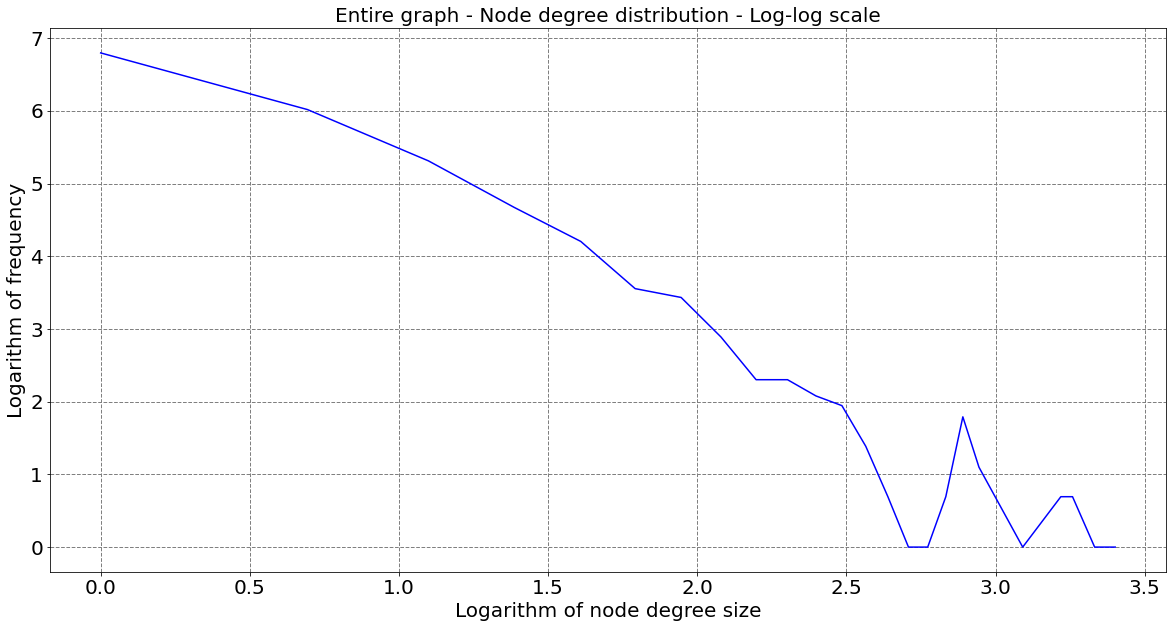

In [31]:
# It should look linear on a log-log scale

log_deg = np.log(deg)
log_cnt = np.log(cnt)

plt.figure(figsize=(20,10))

plt.plot(log_deg, log_cnt, color='b')
plt.xlabel('Logarithm of node degree size', fontsize=20)
plt.ylabel('Logarithm of frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Entire graph - Node degree distribution - Log-log scale", fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.rc('axes', axisbelow=True)
plt.show()

In [32]:
# Fitting a power law distribution

In [33]:
# Power laws are probability distributions with the form:p(x)∝x−α

# Used for degree distribution and powerlaw test
out_degree_sequence = sorted([d for n, d in GG.out_degree()], reverse=True) 

fit = powerlaw.Fit(out_degree_sequence) 

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [34]:
print("alpha:", round(fit.power_law.alpha,3))
print("Kmin:", round(fit.power_law.xmin,3))

alpha: 3.505
Kmin: 6.0


In [35]:
print("Intercept:", round(np.log((fit.power_law.alpha-1)/fit.power_law.xmin),3))
print("Slope:", round(-1*fit.power_law.alpha,3))

Intercept: -0.873
Slope: -3.505


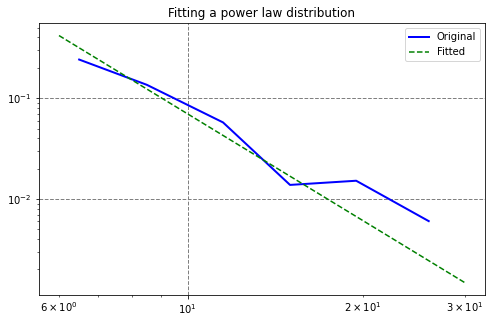

In [36]:
# Plotting the fitted a power law distribution

plt.figure(figsize=(8, 5))
fig2 = fit.plot_pdf(color='b', linewidth=2, label='Original')
fig2 = fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2, label='Fitted')
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.title("Fitting a power law distribution")
plt.rc('axes', axisbelow=True)
plt.legend()

In [37]:
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("R:", R)
print("p:", p)

R: 2.527434799091695
p: 0.011489915627379334


Discussion: As can be seen above, the out degree distribution has the following characteristics: the distribution is right skewed and has a high ratio of max to min. This gives us an indication that it can be very well matched with a power-law distribution. And indeed, in the above procedure it is verified that the out degree distribution fits very well with a power-law distribution. In fact, the likelihood ratio test comparisons produces a pair (R,p), where r is the normalized log likelihood ratio and p is the statistical significance of that ratio. So, being tested for the p-value is whether the sign of r is meaningful. As we can see, we obtained a p<0.05 for a likelihood ratio test, this indicates that the power-law model is favored.

## Reading additional data for ArXiv ID and Paper Title

In [38]:
# Read the ids and titles from "data/oai-arxiv-metadata-hash-abstracts-2019-03-01.json"

#filename = "data/oai-arxiv-metadata-hash-abstracts-2019-03-01.json"
#with open(filename) as f:
#    info_ = [json.loads(line) for line in f]
#info_aXv = pd.DataFrame.from_dict(info_)
#info_aXv = pd.DataFrame({'idAxv':info_aXv["id"], 'title':info_aXv["title"]})
#info_aXv["idAxv"] = info_aXv["idAxv"].apply(lambda x: "x"+str(x))
#info_aXv["title"] = info_aXv["title"].apply(lambda x: x.translate({ord("\n"):None}))
#info_aXv.to_csv("data/infos_idd_names.csv", sep='\t', encoding='utf-8', index=False) # save for future use

In [39]:
# Read the ids and titles from "data/infos_idd_names.csv"

filename = "data/infos_idd_names.csv"
info_aXv = pd.read_csv(filename, sep='\t', index_col=0)
info_aXv.reset_index(inplace=True)
info_aXv["idAxv"] = info_aXv["idAxv"].apply(lambda x: x[1:])

## Measurement of Centralities in the Citation Network

In [40]:
def draw(G, pos, measures, measure_name):
    
    plt.figure(figsize = (40, 30))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=90, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    #labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [41]:
def sorting(cetralts, n_tops):
    cetralts_tops = sorted(cetralts.items(), key=lambda item: item[1], reverse=True)[:n_tops]
    return cetralts_tops

In [42]:
def infos(centrs_tops):
    top_i = 1
    for idd,val in centrs_tops:
        print("Top",str(top_i), ", Id arXiv:", idd, ", Centrality:",round(val,4))
        print("Title:", info_aXv[info_aXv["idAxv"]==idd]["title"].values[0],"\n")
        top_i += 1

## Best centrality for find the 10 most influential papers in arXiv

The most important centrality is PageRank, because this measure uncovers nodes whose influence extends beyond their direct connections into the wider network.

In [43]:
# Page rank centrality
page_rank = nx.pagerank(GG, alpha = 0.85)
page_rank_tops = sorting(page_rank, 10)
infos(page_rank_tops)

Top 1 , Id arXiv: 1705.11098 , Centrality: 0.0024
Title: Modified Gravity Theories on a Nutshell: Inflation, Bounce and Late-time  Evolution 

Top 2 , Id arXiv: 1812.00847 , Centrality: 0.0023
Title: Rescuing Quartic and Natural Inflation in the Palatini Formalism 

Top 3 , Id arXiv: 1811.09514 , Centrality: 0.002
Title: Higgs inflation in the Palatini formulation with kinetic terms for the  metric 

Top 4 , Id arXiv: 1501.05671 , Centrality: 0.002
Title: Resurgence and the Nekrasov-Shatashvili Limit: Connecting Weak and  Strong Coupling in the Mathieu and Lam'e Systems 

Top 5 , Id arXiv: 1607.01001 , Centrality: 0.0019
Title: Dark Matter from a Classically Scale-Invariant $SU(3)_X$ 

Top 6 , Id arXiv: 0710.4947 , Centrality: 0.0018
Title: Physics at a future Neutrino Factory and super-beam facility 

Top 7 , Id arXiv: 1812.11159 , Centrality: 0.0018
Title: Spatially modulated and supersymmetric deformations of ABJM theory 

Top 8 , Id arXiv: 1802.10257 , Centrality: 0.0016
Title: The

In [44]:
#draw(GG, nx.spring_layout(GG), nx.pagerank(GG, alpha = 0.85), 'Page Rank Centrality')

## Measurement of additional centralities for the Citation Network

In [45]:
# In degree centrality
in_deg = nx.in_degree_centrality(GG)
in_deg_tops = sorting(in_deg, 10)
infos(in_deg_tops)

Top 1 , Id arXiv: 1705.11098 , Centrality: 0.0069
Title: Modified Gravity Theories on a Nutshell: Inflation, Bounce and Late-time  Evolution 

Top 2 , Id arXiv: 0710.4947 , Centrality: 0.0056
Title: Physics at a future Neutrino Factory and super-beam facility 

Top 3 , Id arXiv: 1607.01001 , Centrality: 0.0034
Title: Dark Matter from a Classically Scale-Invariant $SU(3)_X$ 

Top 4 , Id arXiv: 1401.1101 , Centrality: 0.0031
Title: Some recent theoretical progress in Higgs boson and top quark physics at  hadron colliders 

Top 5 , Id arXiv: 1503.08622 , Centrality: 0.0028
Title: Lepton flavor violation beyond the MSSM 

Top 6 , Id arXiv: 1502.02866 , Centrality: 0.0028
Title: The nature of the Diffuse Gamma-Ray Background 

Top 7 , Id arXiv: 1103.5939 , Centrality: 0.0028
Title: Beyond The Standard Model: Some Aspects of Supersymmetry and Extra  Dimension 

Top 8 , Id arXiv: hep-ph/0309346 , Centrality: 0.0025
Title: Dark Matter Detection in the Light of Recent Experimental Results 

Top

In [46]:
#draw(GG, nx.spring_layout(GG), nx.in_degree_centrality(GG), 'In Degree Centrality')

In [47]:
# Out degree centrality
out_deg = nx.out_degree_centrality(GG)
out_deg_tops = sorting(out_deg, 10)
infos(out_deg_tops)

Top 1 , Id arXiv: hep-th/0005016 , Centrality: 0.0094
Title: 4D Gravity on a Brane in 5D Minkowski Space 

Top 2 , Id arXiv: hep-th/0501052 , Centrality: 0.0087
Title: Direct Proof Of Tree-Level Recursion Relation In Yang-Mills Theory 

Top 3 , Id arXiv: astro-ph/0306438 , Centrality: 0.0081
Title: Is Cosmic Speed-Up Due to New Gravitational Physics? 

Top 4 , Id arXiv: hep-th/9906070 , Centrality: 0.0081
Title: CFT's From Calabi-Yau Four-folds 

Top 5 , Id arXiv: 1410.3012 , Centrality: 0.0078
Title: An Introduction to PYTHIA 8.2 

Top 6 , Id arXiv: hep-ph/0406184 , Centrality: 0.0078
Title: CP Violation and the CKM Matrix: Assessing the Impact of the Asymmetric  B Factories 

Top 7 , Id arXiv: hep-ph/0105239 , Centrality: 0.0069
Title: Electroweak symmetry breaking from dimensional deconstruction 

Top 8 , Id arXiv: 0907.2694 , Centrality: 0.0059
Title: Emergent quantum criticality, Fermi surfaces, and AdS2 

Top 9 , Id arXiv: hep-th/9602111 , Centrality: 0.0059
Title: Macroscopic En

In [48]:
#draw(GG, nx.spring_layout(GG), nx.out_degree_centrality(GG), 'Out Degree Centrality')

In [49]:
# Closeness centrality
closeness = nx.closeness_centrality(GG)
closeness_tops = sorting(closeness, 10)
infos(closeness_tops)

Top 1 , Id arXiv: 1705.11098 , Centrality: 0.0082
Title: Modified Gravity Theories on a Nutshell: Inflation, Bounce and Late-time  Evolution 

Top 2 , Id arXiv: 1607.01001 , Centrality: 0.0067
Title: Dark Matter from a Classically Scale-Invariant $SU(3)_X$ 

Top 3 , Id arXiv: 1802.06803 , Centrality: 0.0066
Title: Lepton flavour violation in the MSSM: exact diagonalization vs mass  expansion 

Top 4 , Id arXiv: 1707.01286 , Centrality: 0.0059
Title: Matter Parity Violating Dark Matter Decay in Minimal SO(10),  Unification, Vacuum Stability and Verifiable Proton Decay 

Top 5 , Id arXiv: 1810.07711 , Centrality: 0.0057
Title: Logarithmic-corrected $R^2$ Gravity Inflation in the Presence of  Kalb-Ramond Fields 

Top 6 , Id arXiv: 0710.4947 , Centrality: 0.0056
Title: Physics at a future Neutrino Factory and super-beam facility 

Top 7 , Id arXiv: 1707.04494 , Centrality: 0.0056
Title: Excavating black hole continuum spectrum: Possible signatures of scalar  hairs and of higher dimensions 

In [50]:
#draw(GG, nx.spring_layout(GG), nx.closeness_centrality(GG), 'Closeness Centrality')

In [51]:
# Eigenvector centrality
eig = nx.eigenvector_centrality(GG, max_iter=600)
eig_tops = sorting(eig, 10)
infos(eig_tops)

Top 1 , Id arXiv: hep-th/0406225 , Centrality: 0.4835
Title: Resolving the Holography in the Plane-Wave Limit of AdS/CFT  Correspondence 

Top 2 , Id arXiv: 0907.1567 , Centrality: 0.3987
Title: Operator mixing and three-point functions in N=4 SYM 

Top 3 , Id arXiv: 0706.3751 , Centrality: 0.365
Title: The AdS/CFT Correspondence: Classical, Quantum, and Thermodynamical  Aspects 

Top 4 , Id arXiv: hep-th/0609007 , Centrality: 0.365
Title: Holography of Wilson-Loop Expectation Values with Local Operator  Insertions 

Top 5 , Id arXiv: hep-th/0403188 , Centrality: 0.354
Title: Fermion BMN operators, the dilatation operator of N=4 SYM, and pp-wave  string interactions 

Top 6 , Id arXiv: 1105.1537 , Centrality: 0.2755
Title: On strong-coupling correlation functions of circular Wilson loops and  local operators 

Top 7 , Id arXiv: 1106.5656 , Centrality: 0.208
Title: Three-point Correlation Function of Giant Magnons in the Lunin-Maldacena  background 

Top 8 , Id arXiv: hep-th/0302064 , C

In [52]:
#draw(GG, nx.spring_layout(GG), nx.eigenvector_centrality(GG, max_iter=600), 'Eigenvector Centrality')

In [53]:
# Betweeness centrality
betw = nx.betweenness_centrality(GG)
betw_tops = sorting(betw, 10)
infos(betw_tops)

Top 1 , Id arXiv: hep-th/9701025 , Centrality: 0.0001
Title: Proposals on nonperturbative superstring interactions 

Top 2 , Id arXiv: hep-th/9906070 , Centrality: 0.0001
Title: CFT's From Calabi-Yau Four-folds 

Top 3 , Id arXiv: 0710.4947 , Centrality: 0.0001
Title: Physics at a future Neutrino Factory and super-beam facility 

Top 4 , Id arXiv: hep-th/9809162 , Centrality: 0.0001
Title: A Relation Between N=8 Gauge Theories in Three Dimensions 

Top 5 , Id arXiv: hep-th/9702187 , Centrality: 0.0001
Title: Strings from Matrices 

Top 6 , Id arXiv: hep-th/9607201 , Centrality: 0.0001
Title: Lectures on Superstring and M Theory Dualities 

Top 7 , Id arXiv: 1410.3012 , Centrality: 0.0001
Title: An Introduction to PYTHIA 8.2 

Top 8 , Id arXiv: 1202.0822 , Centrality: 0.0001
Title: A 119-125 GeV Higgs from a string derived slice of the CMSSM 

Top 9 , Id arXiv: hep-th/0005049 , Centrality: 0.0001
Title: Supergravity flows and D-brane stability 

Top 10 , Id arXiv: 1503.08622 , Centralit

In [54]:
#draw(GG, nx.spring_layout(GG), nx.betweenness_centrality(GG), 'Betweeness Centrality')

In [55]:
# Katz centrality
katz = nx.katz_centrality(GG, alpha=0.1, beta=1.0)
katz_tops = sorting(katz, 10)
infos(katz_tops)

Top 1 , Id arXiv: 1705.11098 , Centrality: 0.0519
Title: Modified Gravity Theories on a Nutshell: Inflation, Bounce and Late-time  Evolution 

Top 2 , Id arXiv: 0710.4947 , Centrality: 0.0439
Title: Physics at a future Neutrino Factory and super-beam facility 

Top 3 , Id arXiv: 1607.01001 , Centrality: 0.0354
Title: Dark Matter from a Classically Scale-Invariant $SU(3)_X$ 

Top 4 , Id arXiv: 1401.1101 , Centrality: 0.0326
Title: Some recent theoretical progress in Higgs boson and top quark physics at  hadron colliders 

Top 5 , Id arXiv: 1503.08622 , Centrality: 0.0312
Title: Lepton flavor violation beyond the MSSM 

Top 6 , Id arXiv: 1103.5939 , Centrality: 0.0305
Title: Beyond The Standard Model: Some Aspects of Supersymmetry and Extra  Dimension 

Top 7 , Id arXiv: 1502.02866 , Centrality: 0.0301
Title: The nature of the Diffuse Gamma-Ray Background 

Top 8 , Id arXiv: 1809.09744 , Centrality: 0.028
Title: Effective Field Theory in the top sector: do multijets help? 

Top 9 , Id ar

In [56]:
#draw(GG, nx.spring_layout(GG), nx.katz_centrality(GG, alpha=0.1, beta=1.0), 'Katz Centrality')

In [57]:
# Hub scores
hubs, authorities = nx.hits(GG, max_iter=600)
hubs_tops = sorting(hubs, 10)
infos(hubs_tops)

Top 1 , Id arXiv: hep-th/0005016 , Centrality: 0.1922
Title: 4D Gravity on a Brane in 5D Minkowski Space 

Top 2 , Id arXiv: astro-ph/0306438 , Centrality: 0.1725
Title: Is Cosmic Speed-Up Due to New Gravitational Physics? 

Top 3 , Id arXiv: astro-ph/0302506 , Centrality: 0.0369
Title: Phantom Energy and Cosmic Doomsday 

Top 4 , Id arXiv: astro-ph/0307285 , Centrality: 0.0369
Title: Can modified gravity explain accelerated cosmic expansion? 

Top 5 , Id arXiv: astro-ph/0407107 , Centrality: 0.02
Title: Can dark energy evolve to the Phantom? 

Top 6 , Id arXiv: 1704.05945 , Centrality: 0.0174
Title: Constant-roll Inflation in $F(R)$ Gravity 

Top 7 , Id arXiv: 1304.0363 , Centrality: 0.017
Title: Multifield Inflation after Planck: The Case for Nonminimal Couplings 

Top 8 , Id arXiv: 1003.3009 , Centrality: 0.0164
Title: Constraints on f(R) gravity from probing the large-scale structure 

Top 9 , Id arXiv: astro-ph/0405353 , Centrality: 0.0164
Title: The Phantom Bounce: A New Oscillat

In [58]:
#draw(GG, nx.spring_layout(GG), nx.hits(GG, max_iter=600)[0], 'Hub Scores')

In [59]:
# Authority scores
hubs, authorities = nx.hits(GG, max_iter=600)
authorities_tops = sorting(authorities, 10)
infos(authorities_tops)

Top 1 , Id arXiv: 1705.11098 , Centrality: 0.0426
Title: Modified Gravity Theories on a Nutshell: Inflation, Bounce and Late-time  Evolution 

Top 2 , Id arXiv: hep-th/0407090 , Centrality: 0.0325
Title: Accelerated Cosmological Models in Ricci squared Gravity 

Top 3 , Id arXiv: 0809.3730 , Centrality: 0.0303
Title: Experimental Tests of General Relativity: Recent Progress and Future  Directions 

Top 4 , Id arXiv: 0706.0857 , Centrality: 0.0295
Title: Stealth Acceleration and Modified Gravity 

Top 5 , Id arXiv: 0708.1611 , Centrality: 0.0295
Title: DGP Cosmology with a Non-Minimally Coupled Scalar Field on the Brane 

Top 6 , Id arXiv: 1511.00376 , Centrality: 0.0287
Title: Exact Cosmological Solutions of $f(R)$ Theories via Hojman Symmetry 

Top 7 , Id arXiv: hep-th/0506137 , Centrality: 0.0287
Title: Constraints on Gauss-Bonnet Gravity in Dark Energy Cosmologies 

Top 8 , Id arXiv: 1003.0409 , Centrality: 0.0287
Title: Dynamical Masses in Modified Gravity 

Top 9 , Id arXiv: 1511.

In [60]:
#draw(GG, nx.spring_layout(GG), nx.hits(GG, max_iter=600)[1], 'Authority Scores')

In [61]:
# Harmonic centrality
harmonic = nx.harmonic_centrality(GG)
harmonic_tops = sorting(harmonic, 10)
infos(harmonic_tops)

Top 1 , Id arXiv: 1607.01001 , Centrality: 31.0996
Title: Dark Matter from a Classically Scale-Invariant $SU(3)_X$ 

Top 2 , Id arXiv: 1705.11098 , Centrality: 30.5
Title: Modified Gravity Theories on a Nutshell: Inflation, Bounce and Late-time  Evolution 

Top 3 , Id arXiv: 1802.06803 , Centrality: 27.3734
Title: Lepton flavour violation in the MSSM: exact diagonalization vs mass  expansion 

Top 4 , Id arXiv: 1707.01286 , Centrality: 25.6067
Title: Matter Parity Violating Dark Matter Decay in Minimal SO(10),  Unification, Vacuum Stability and Verifiable Proton Decay 

Top 5 , Id arXiv: 1503.08622 , Centrality: 24.2484
Title: Lepton flavor violation beyond the MSSM 

Top 6 , Id arXiv: 1701.02463 , Centrality: 23.7844
Title: Hunting for Heavy Majorana Neutrinos with Lepton Number Violating  Signatures at LHC 

Top 7 , Id arXiv: 0710.4947 , Centrality: 22.75
Title: Physics at a future Neutrino Factory and super-beam facility 

Top 8 , Id arXiv: 1605.06091 , Centrality: 21.7132
Title: Hi

In [62]:
#draw(GG, nx.spring_layout(GG), nx.harmonic_centrality(GG), 'Harmonic Centrality')

## Overview of all the centralities of the Citation Network

In [63]:
# Collecting centralities in a single dataframe
data_tmp = {'page rank': list(dict(page_rank_tops).keys()),
            'in degree': list(dict(in_deg_tops).keys()), 
            'out degree': list(dict(out_deg_tops).keys()),
            'closeness': list(dict(closeness_tops).keys()),
            'eigenvector': list(dict(eig_tops).keys()),
            'betweeness': list(dict(betw_tops).keys()),
            'katz': list(dict(katz_tops).keys()),
            'hub scores': list(dict(hubs_tops).keys()),
            'authority scores': list(dict(authorities_tops).keys()),
            'harmonic': list(dict(harmonic_tops).keys())}
df_centralities = pd.DataFrame(data_tmp)
df_centralities

page rank       in degree        out degree   closeness     eigenvector  \
0  1705.11098      1705.11098    hep-th/0005016  1705.11098  hep-th/0406225   
1  1812.00847       0710.4947    hep-th/0501052  1607.01001       0907.1567   
2  1811.09514      1607.01001  astro-ph/0306438  1802.06803       0706.3751   
3  1501.05671       1401.1101    hep-th/9906070  1707.01286  hep-th/0609007   
4  1607.01001      1503.08622         1410.3012  1810.07711  hep-th/0403188   
5   0710.4947      1502.02866    hep-ph/0406184   0710.4947       1105.1537   
6  1812.11159       1103.5939    hep-ph/0105239  1707.04494       1106.5656   
7  1802.10257  hep-ph/0309346         0907.2694  1503.08622  hep-th/0302064   
8  1502.02866      1511.03702    hep-th/9602111  1806.07052  hep-th/0209244   
9  1901.11298       0803.0494    hep-th/0208048  1711.05140  hep-th/0208231   

       betweeness        katz        hub scores authority scores    harmonic  
0  hep-th/9701025  1705.11098    hep-th/0005016       1705.11098  1607.01001  
1  hep-th/9906070   0710.4947  astro-ph/0306438   hep-th/0407090  1705.11098  
2       0710.4947  1607.01001  astro-ph/0302506        0809.3730  1802.06803  
3  hep-th/9809162   1401.1101  astro-ph/0307285        0706.0857  1707.01286  
4  hep-th/9702187  1503.08622  astro-ph/0407107        0708.1611  1503.08622  
5  hep-th/9607201   1103.5939        1704.05945       1511.00376  1701.02463  
6       1410.3012  1502.02866         1304.0363   hep-th/0506137   0710.4947  
7       1202.0822  1809.09744         1003.3009        1003.0409  1605.06091  
8  hep-th/0005049  1808.07340  astro-ph/0405353       1511.05734  1810.07711  
9      1503.08622  1707.01286  astro-ph/0412308        1008.4421  1511.00979

From the table above we can see that several papers or nodes within the top 10 of Page Rank centrality such as 0809.1869, 1611.05079, 1309.3638, and 1605.02016 are repeated in the top 10 measures of various centralities, this because these nodes are the most influential in the network, and therefore it is expected that they appear in several places in the table. 

In addition, several of the Page Rank values seen in the table coincide with the Katz values, and this is because the Page Rank centrality measure is an improvement of the Katz centrality.

As mentioned above, from the definition of Page Rank centrality, it is concluded that it is the best option to find the most influential papers in arXiv.

## Implementing the Field Category Network

In [64]:
# Filtering only fields

df_filt = df

df_filt = df_filt[df_filt["top"].apply(lambda x: True if (x.find('/')!=-1) else False)]
df_filt = df_filt[df_filt["sub"].apply(lambda x: True if (x.find('/')!=-1) else False)]
df_filt = df_filt[df_filt["top"].apply(lambda x: True if (x[0].isnumeric()!=True) else False)]
df_filt = df_filt[df_filt["sub"].apply(lambda x: True if (x[0].isnumeric()!=True) else False)]

print(df_filt.shape)
df_filt.head()

(1352, 2)


top             sub
1   hep-th/0104081  hep-th/0404174
3   hep-th/0104081    math/0210451
13  hep-ph/9903460  hep-ph/0204360
14  hep-ph/0108005  hep-ph/0204360
15  hep-ph/0110366  hep-ph/0204360

In [65]:
# Construct dataframe

fields_main = df_filt["top"].apply(lambda x: x[0:x.find('/')])
fields_refs = df_filt["sub"].apply(lambda x: x[0:x.find('/')])

df_fields = pd.DataFrame({'top':fields_main, 'sub':fields_refs})
df_fields = df_fields.reset_index(drop=True)

print(df_fields.shape)
df_fields.head()

(1352, 2)


top     sub
0  hep-th  hep-th
1  hep-th    math
2  hep-ph  hep-ph
3  hep-ph  hep-ph
4  hep-ph  hep-ph

In [66]:
# Complete the number of citations between fields

df_fields = df_fields.groupby(df_fields.columns.tolist()).size().reset_index().rename(columns={0:'count'})

print(df_fields.shape)
df_fields.head()

(59, 3)


top       sub  count
0  alg-geom    hep-th      3
1  astro-ph  astro-ph     92
2  astro-ph  cond-mat      1
3  astro-ph     gr-qc     20
4  astro-ph    hep-ph     13

In [67]:
# Filter count >= 3
df_fields = df_fields[df_fields["count"]>=3]

print(df_fields.shape)
df_fields.head()

(35, 3)


top       sub  count
0  alg-geom    hep-th      3
1  astro-ph  astro-ph     92
3  astro-ph     gr-qc     20
4  astro-ph    hep-ph     13
5  astro-ph    hep-th      7

In [68]:
# Filter fields that reference itselfs
df_fields = df_fields[df_fields["top"]!=df_fields["sub"]]

print(df_fields.shape)
df_fields.head()

(25, 3)


top     sub  count
0   alg-geom  hep-th      3
3   astro-ph   gr-qc     20
4   astro-ph  hep-ph     13
5   astro-ph  hep-th      7
10  cond-mat  hep-th      3

In [69]:
# Saving for use in Cytoscape
df_fields.to_csv("cytoscape/fields_network.csv", sep='\t', encoding='utf-8', index=False)

In [70]:
GG_fields = nx.from_pandas_edgelist(df_fields, source="top",
                                    target="sub", edge_attr="count",
                                    create_using=nx.DiGraph())
print(nx.info(GG_fields))

Name: 
Type: DiGraph
Number of nodes: 12
Number of edges: 25
Average in degree:   2.0833
Average out degree:   2.0833


## Visualization of the Field Category Network using NetworkX

The size of each node is a function of the centrality of the in degree and the width of each edge is a function of the count values

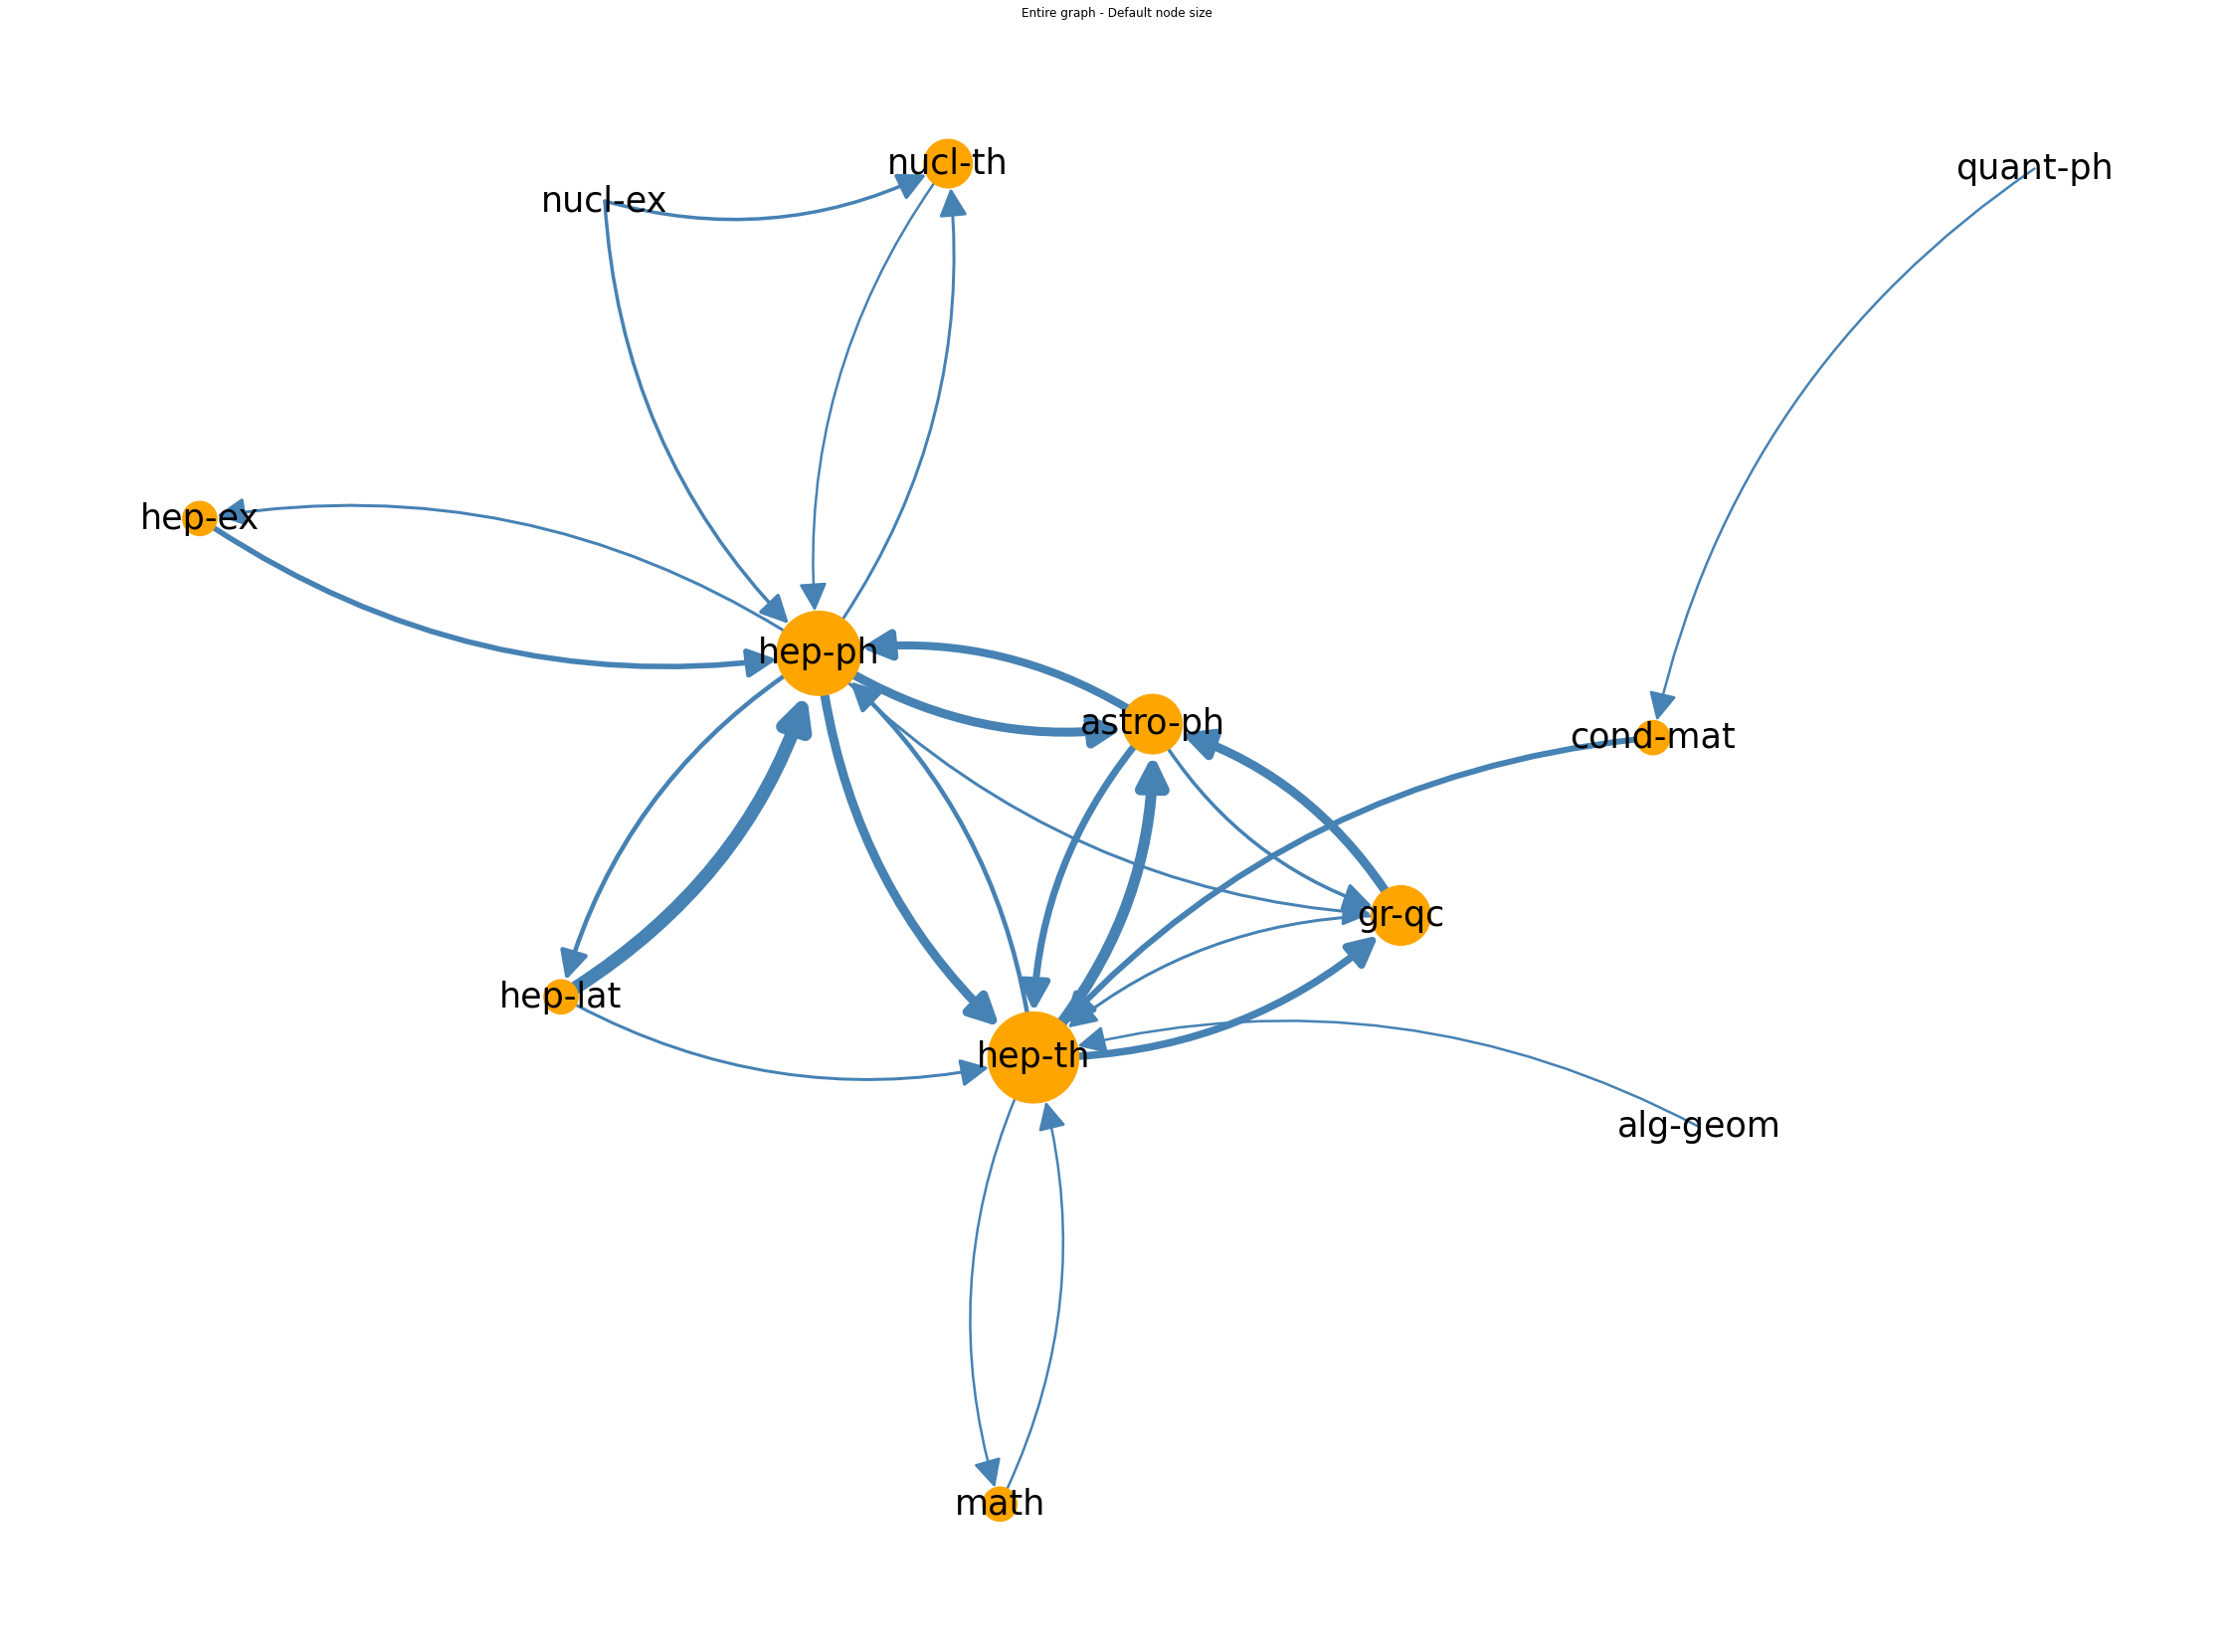

In [71]:
spring_pos = nx.spring_layout(GG_fields) # might take a little while
fig = plt.figure(figsize = (40, 30))
ax = fig.add_subplot(111)
ax.axis('off')

nx.draw_networkx(GG_fields,
                 spring_pos,
                 ax = ax,
                 node_color='orange',
                 node_size=[v*1200 for v in dict(GG_fields.in_degree()).values()],
                 font_size=35,
                 with_labels=True,
                 arrowsize=60,
                 width=list(1+df_fields["count"].values/2),
                 connectionstyle="arc3,rad=0.2",
                 edge_color='steelblue')
plt.title("Entire graph - Default node size")
plt.close();

fig

## Visualization of the Field Category Network using Cytoscape

The size of each node is a function of the centrality of the in degree and the width of each edge is a function of the count values

The Cytoscape file is located in the folder "cytoscape"

<p align="center">
<img src="cytoscape/fields_network.png" alt="Flowchart" width="900"/>
</p>

## References

- [Clement, C. B., Bierbaum, M., O’Keeffe, K. P., & Alemi, A. A. (2019). On the Use of ArXiv as a Dataset. arXiv [cs.IR]. Opgehaal van http://arxiv.org/abs/1905.00075](https://arxiv.org/pdf/1905.00075.pdf)


- [Clauset, A., Shalizi, C. R., & Newman, M. E. J. (2009). Power-Law Distributions in Empirical Data. SIAM Review, 51(4), 661–703. doi:10.1137/070710111](https://arxiv.org/pdf/0706.1062.pdf)


- [Page, L., Brin, S., Motwani, R., & Winograd, T. (1998). The PageRank Citation Ranking: Bringing Order to the Web.](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf)